# mRNA self-regulation Specific Visualization

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [3]:
prob_name = "mRNA_self_reg"
methods = ["smc", "pmc", "ptmcmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))		

<class 'pypesto.problem.base.Problem'>


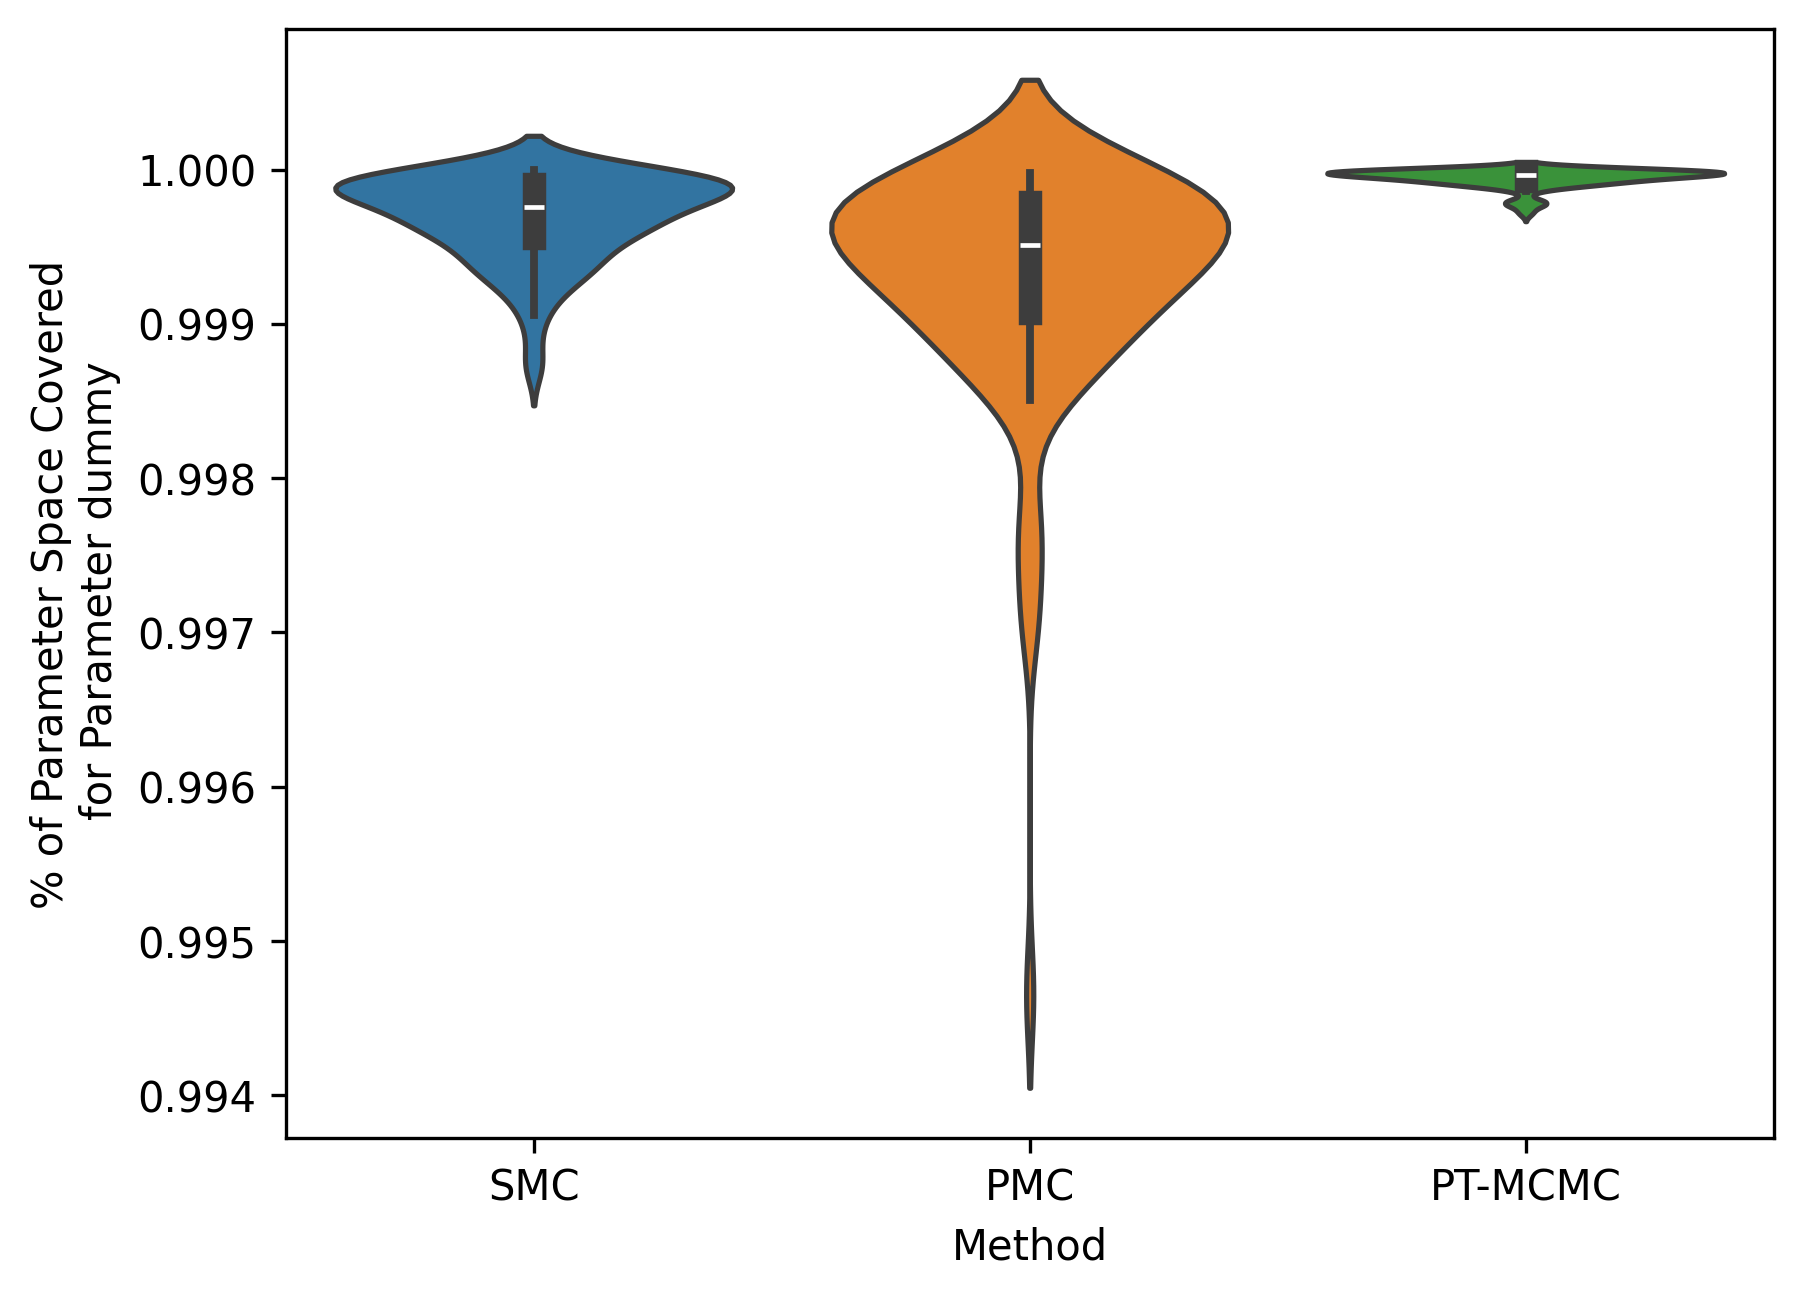

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -1

par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx, inlog=True) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.violinplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[dummy_idx]} ");

## Select best result for each method

In [5]:
llhs = np.array([x.get_llhs() for x in grouped_results])
best_runs = [np.argmax(np.max(x, axis=1)) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

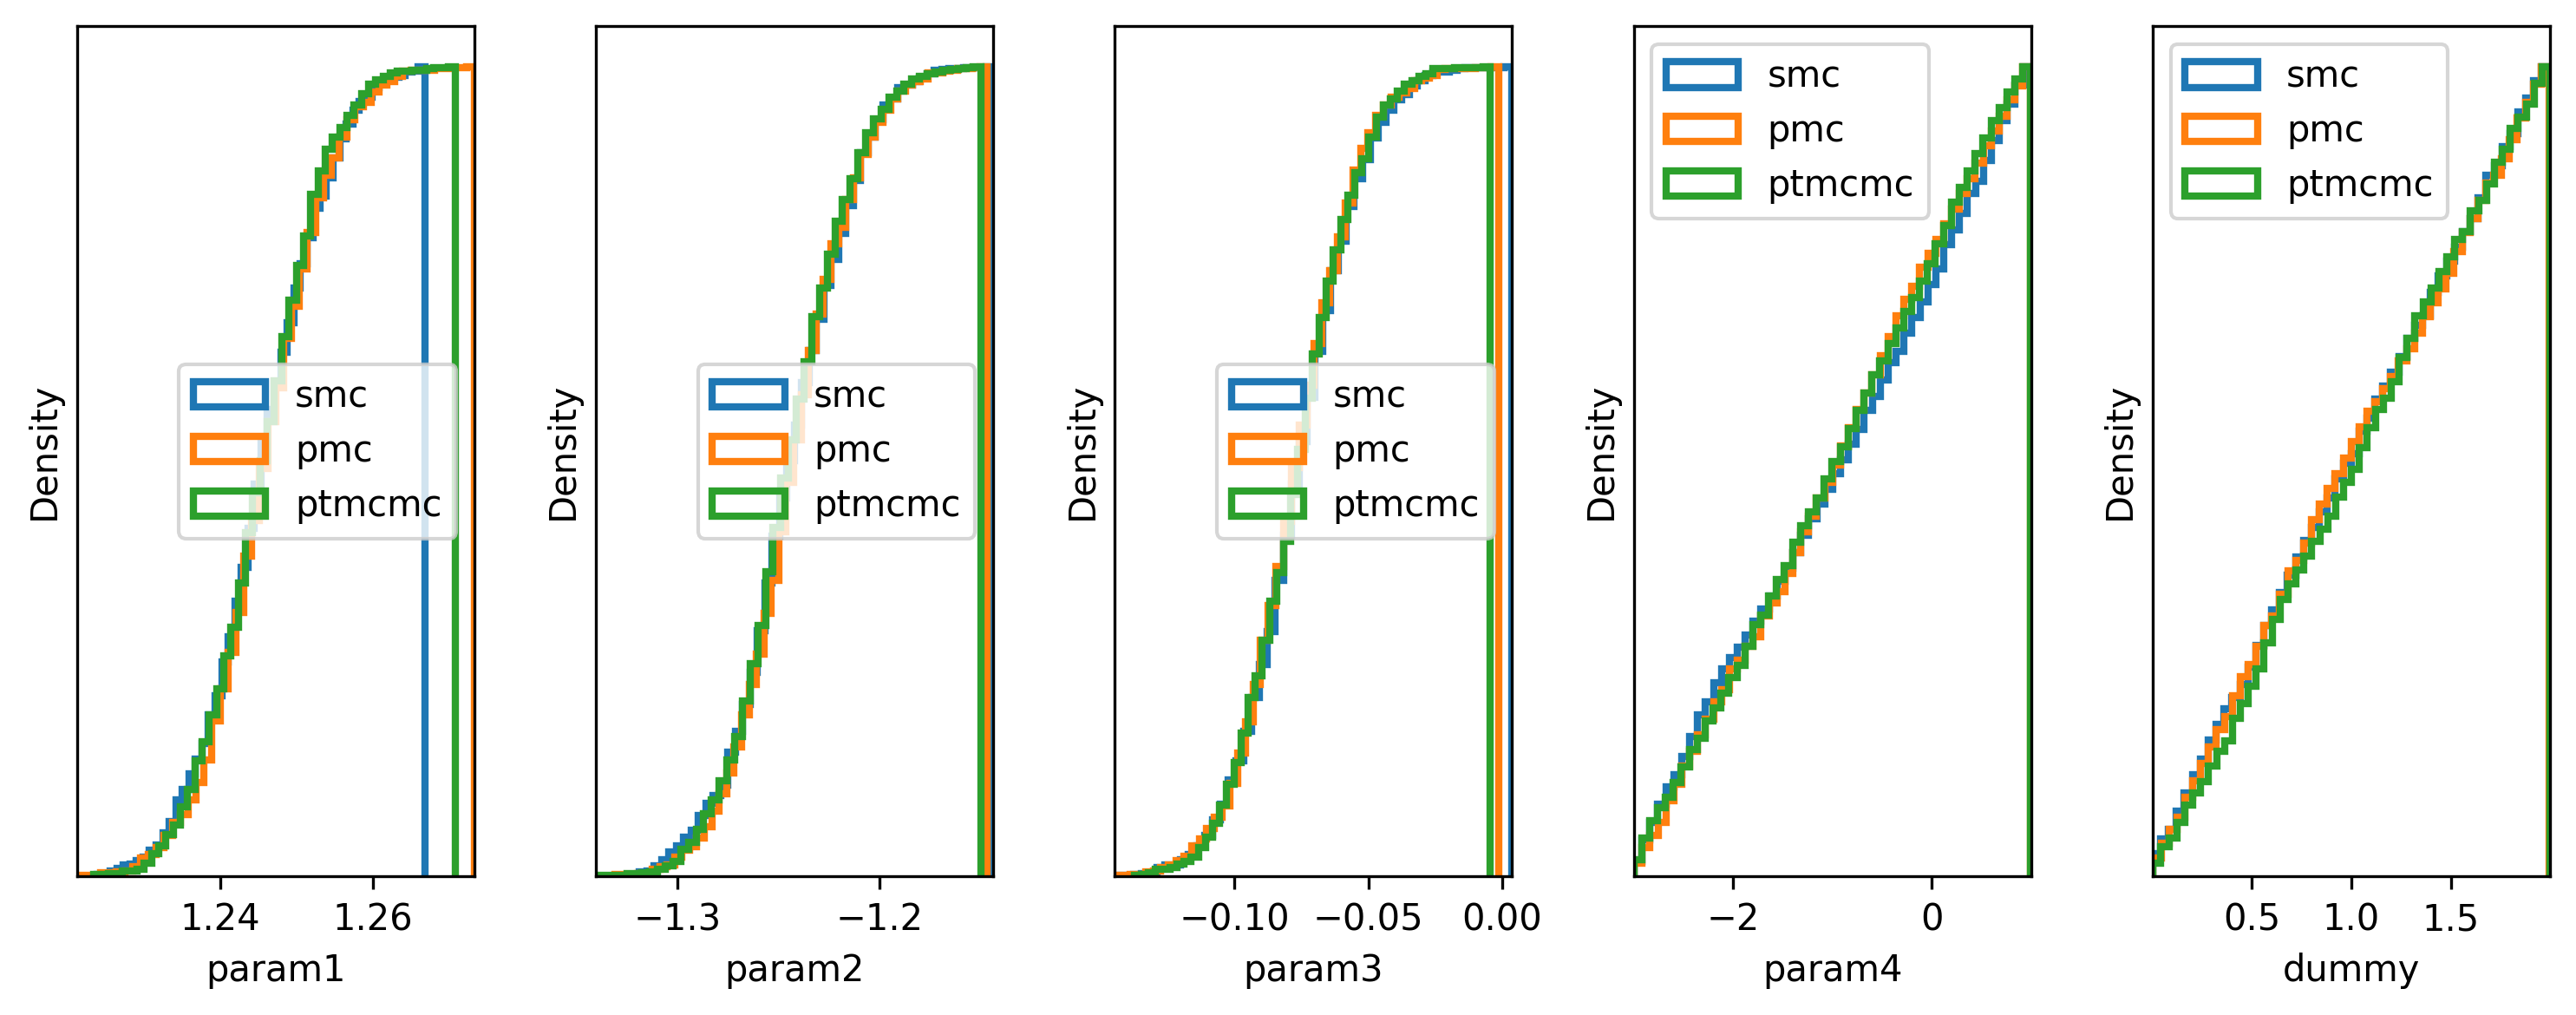

In [6]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

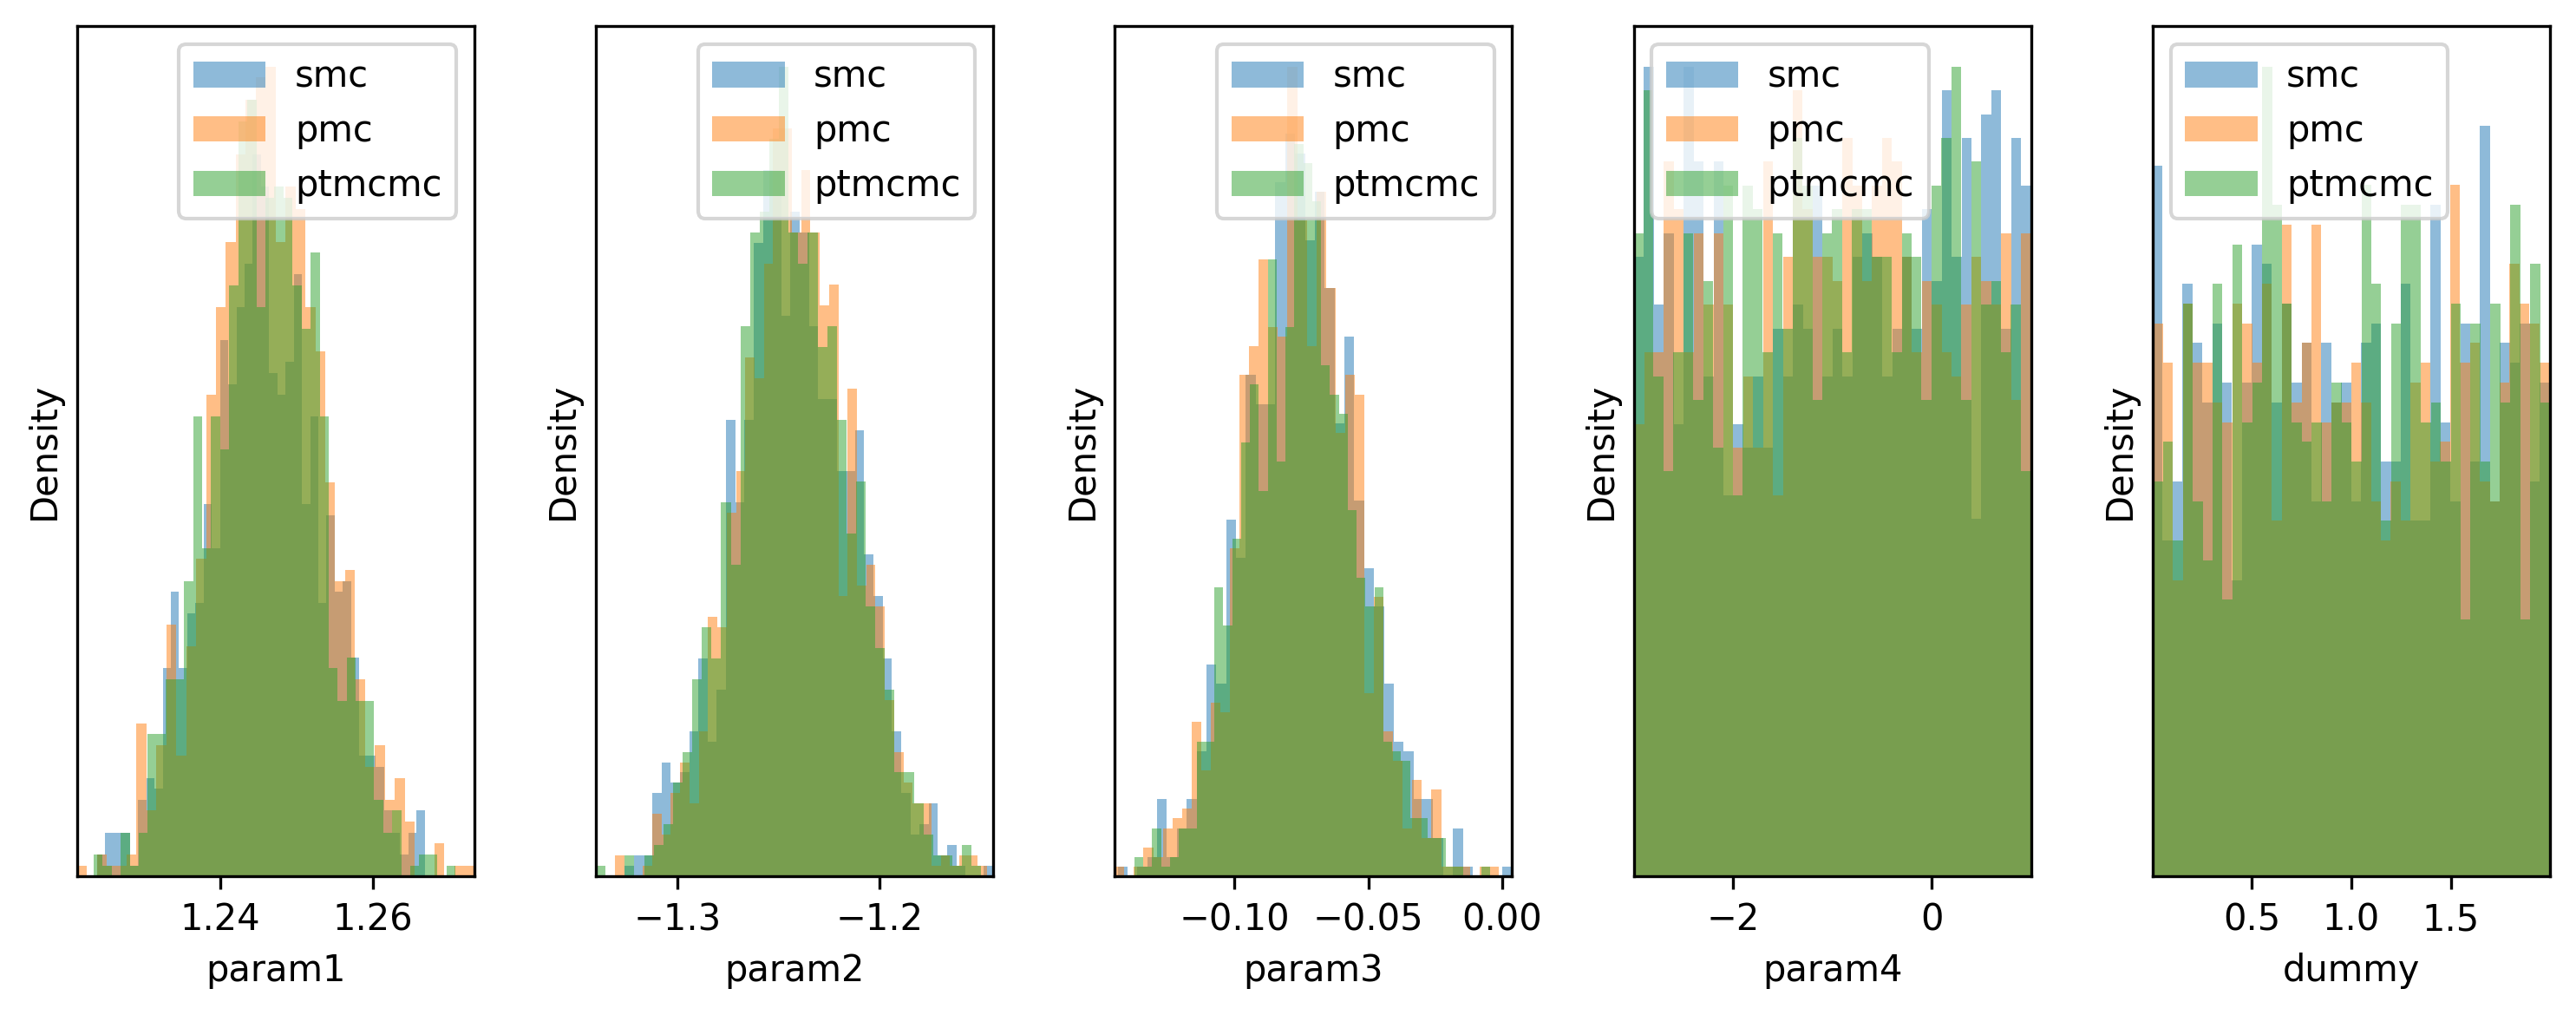

In [7]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

param1	True:0.5	17.61659959680336	1.245860992064336
param2	True:10.0	0.05731396514758342	-1.2426672646258243
param3	True:2.0	0.8416915011553683	-0.07532353033681707
param4	True:1.0	1.0062411123664448	-0.9894868138158712
dummy	True:5.0	21.62029547095134	1.015479656197353


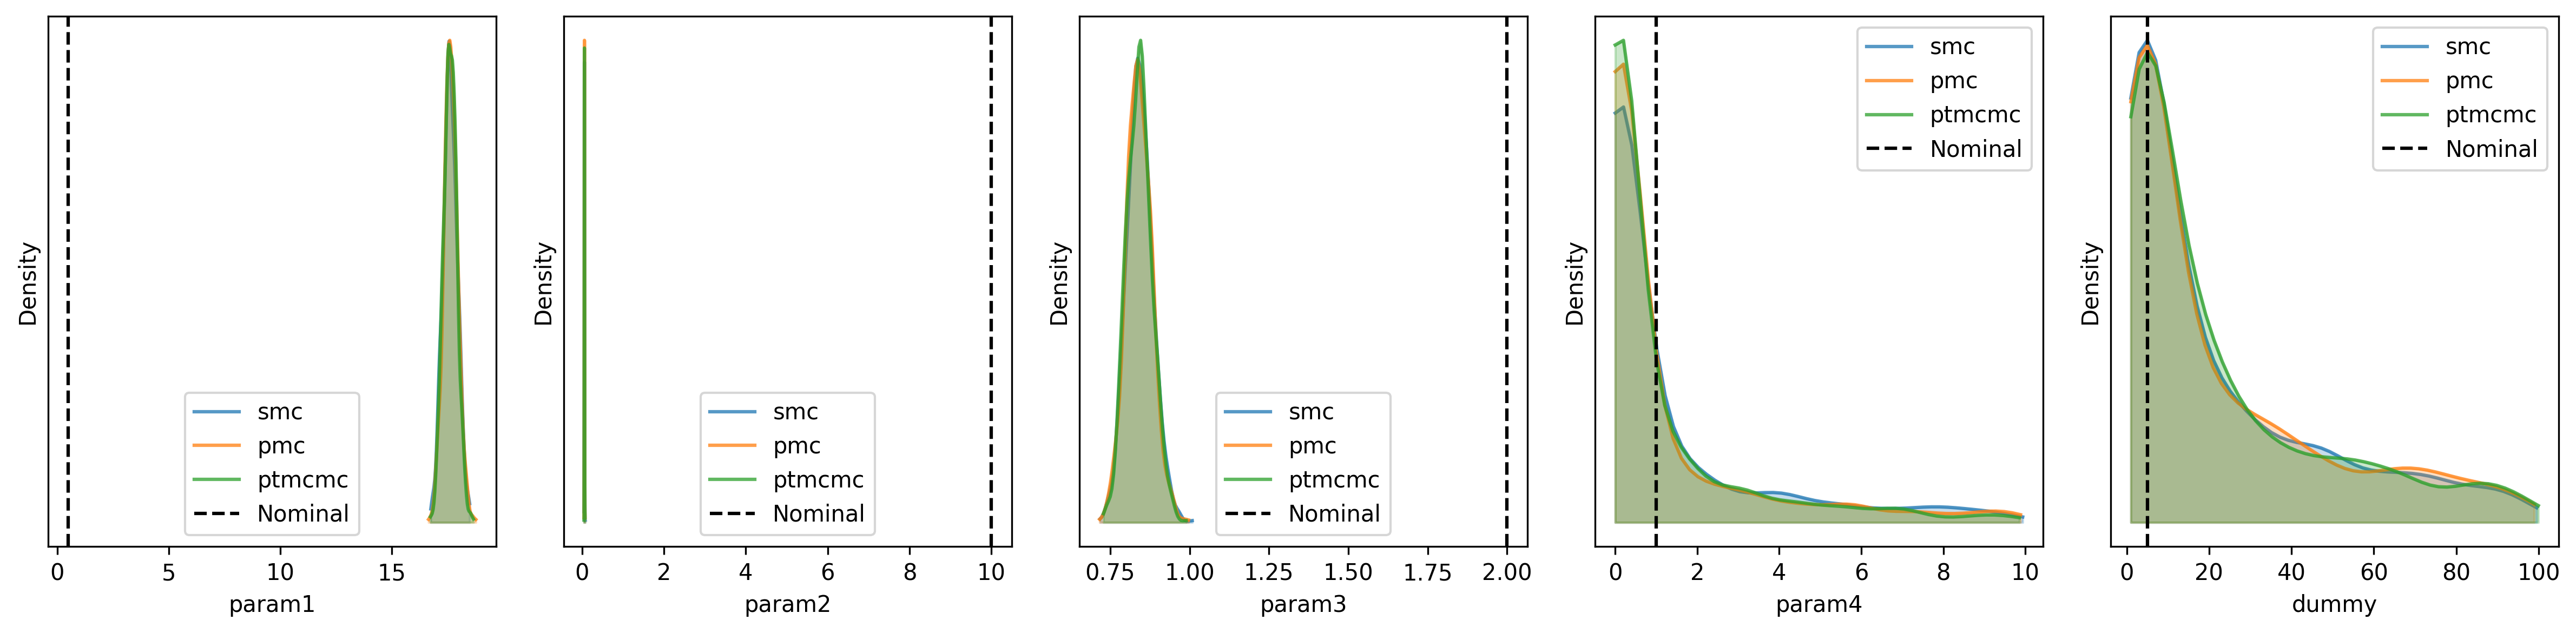

In [18]:
import scipy.stats as st
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
plt.figure(figsize=(16,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		param_samples = 10**cur_result.posterior_samples[:, i]
		norm_ws = cur_result.posterior_weights
		kde = st.gaussian_kde(param_samples, weights=norm_ws)
		x = np.linspace(np.min(param_samples), np.max(param_samples), 50)
		plt.plot(x, kde(x), '-', color=colors[j], alpha=0.75, zorder=1, label=cur_result.method)
		plt.fill_between(x, kde(x), alpha=0.25, color=colors[j], zorder=1)
	print(f"{par_name}\tTrue:{xtrue[i]}\t{np.average(param_samples)}\t{np.average(np.log10(param_samples))}")
	plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal")
	plt.xlabel(par_name)
	plt.yticks([])
	plt.ylabel("Density")
	#plt.margins(x=0, y=0.001)
	plt.legend()
plt.tight_layout()

In [17]:
np.log10(2)

0.3010299956639812

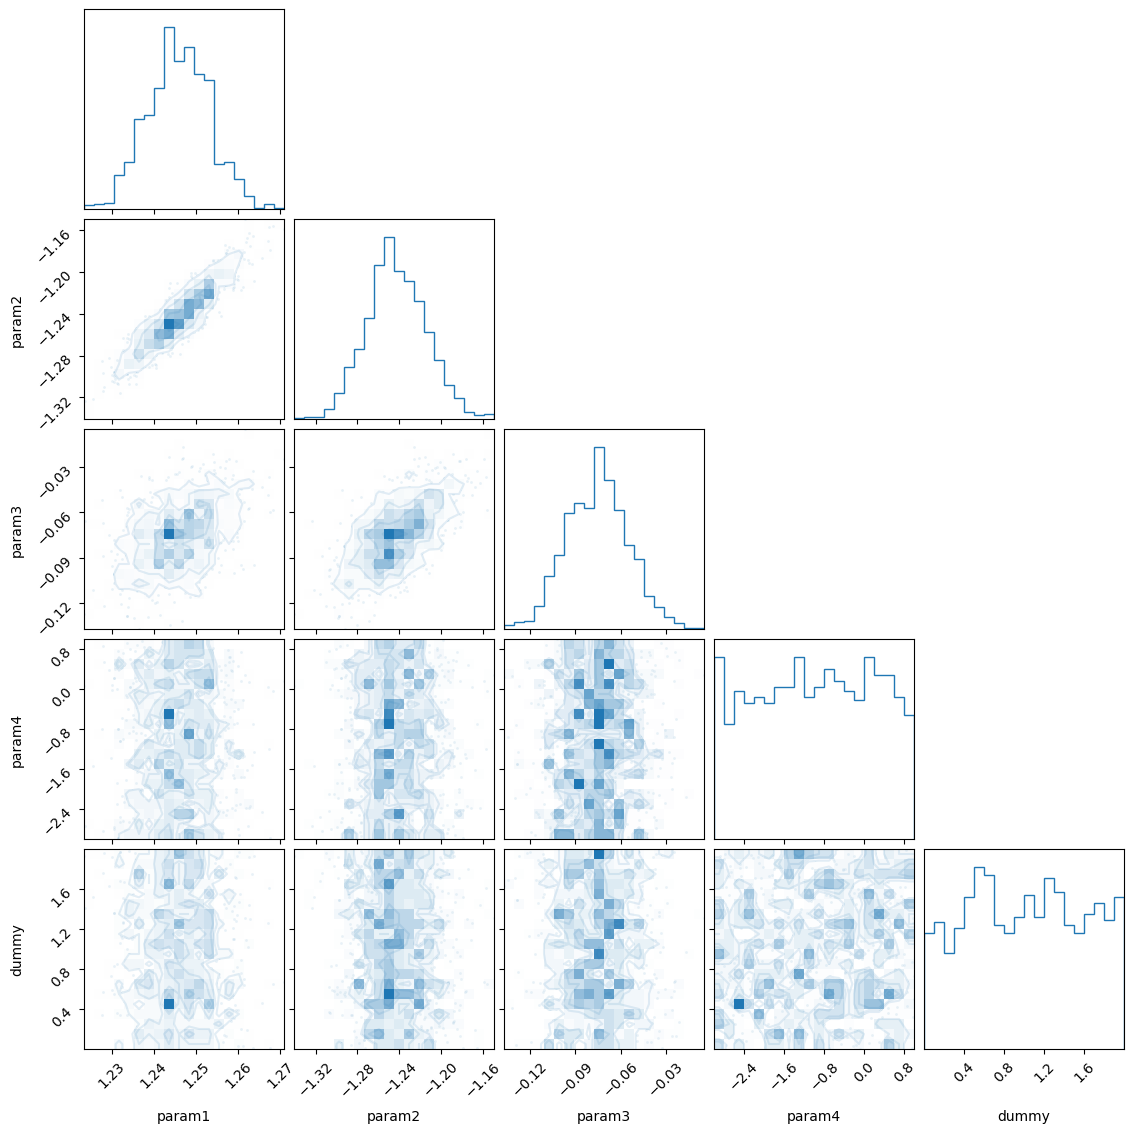

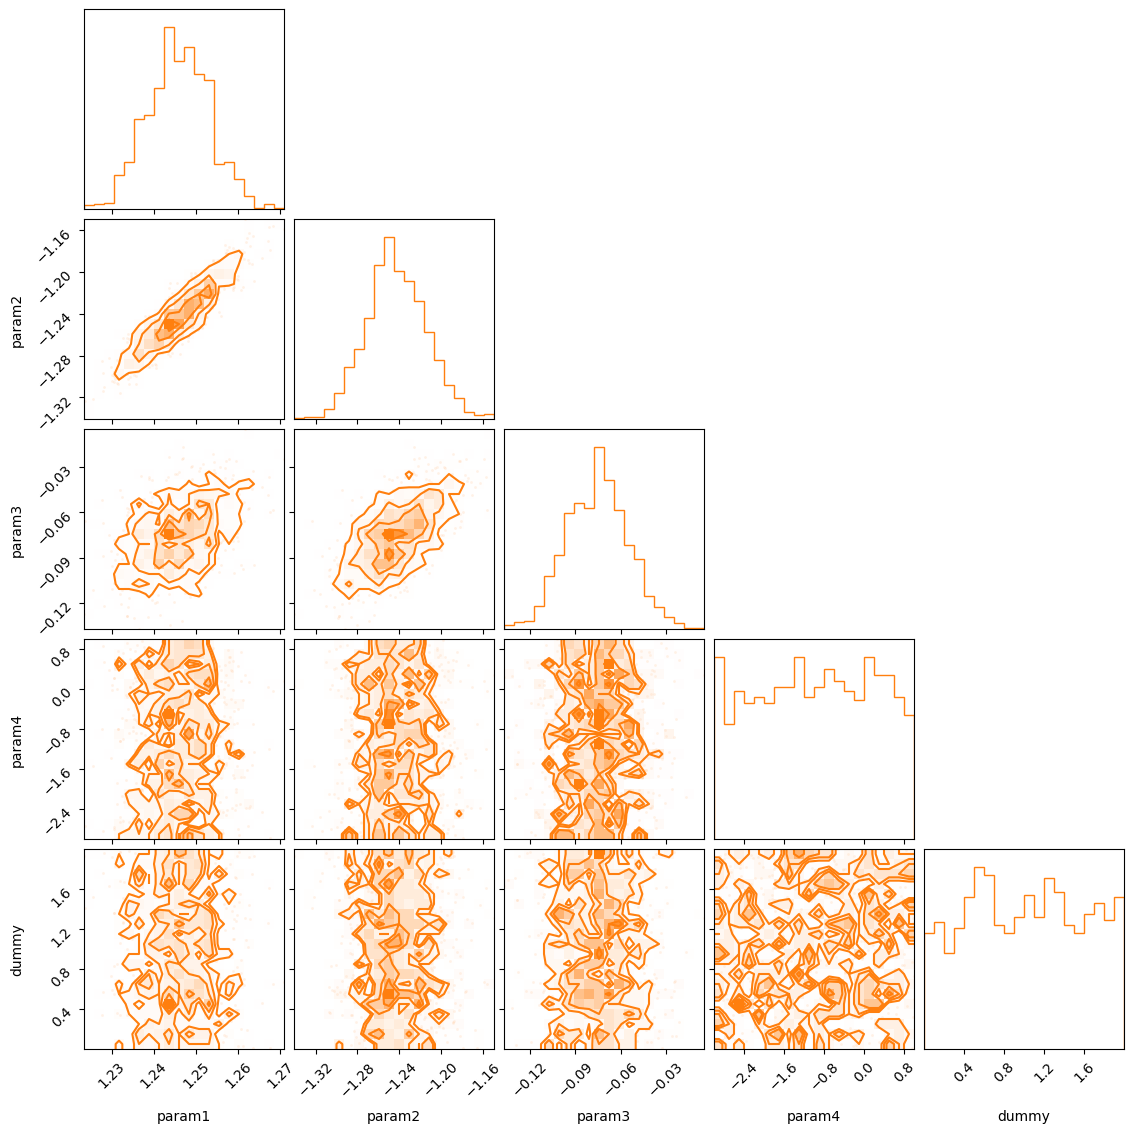

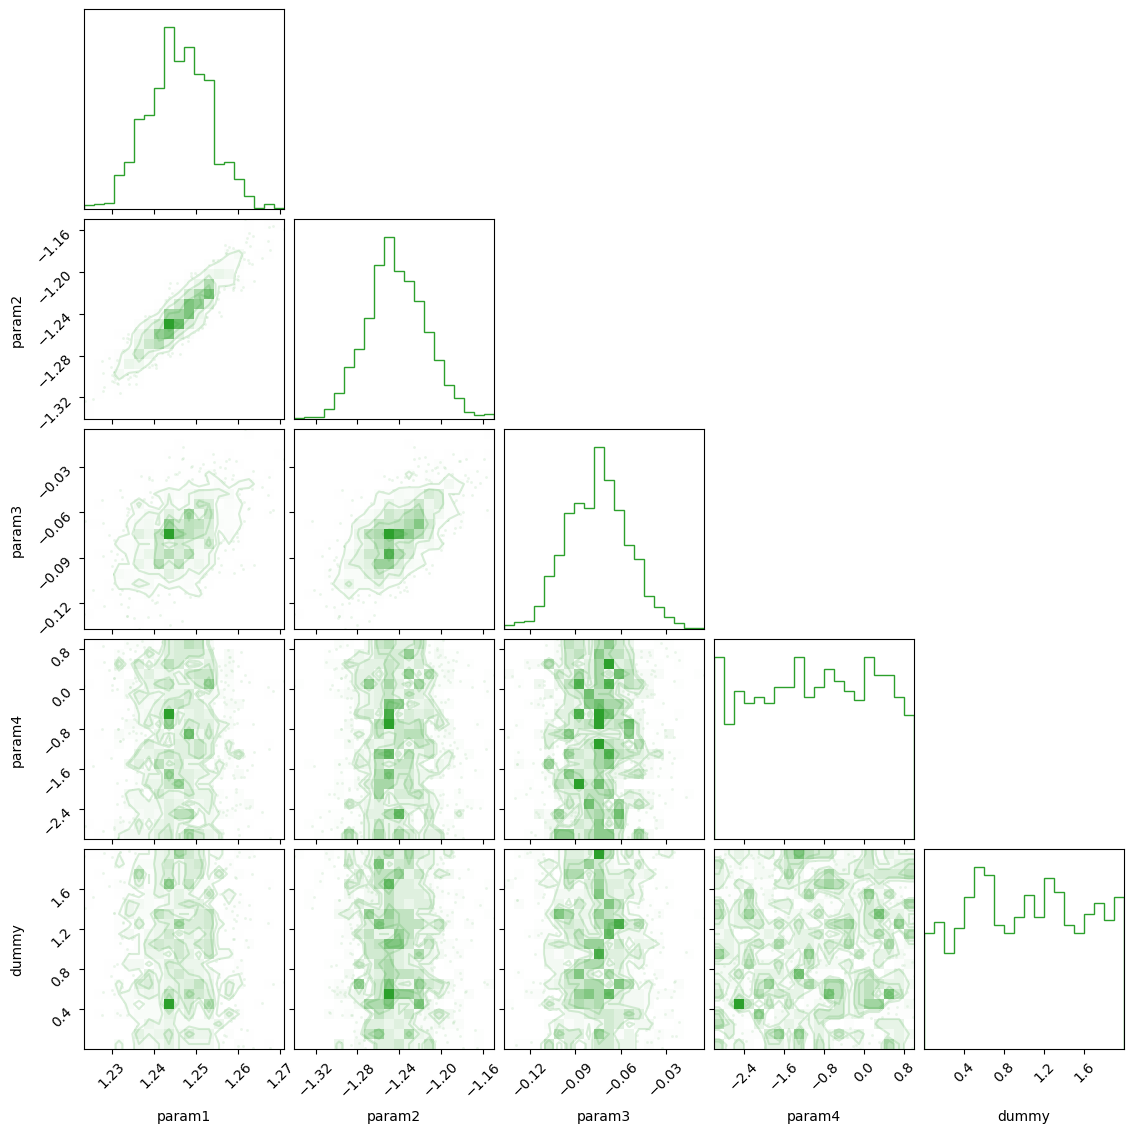

In [9]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[j]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

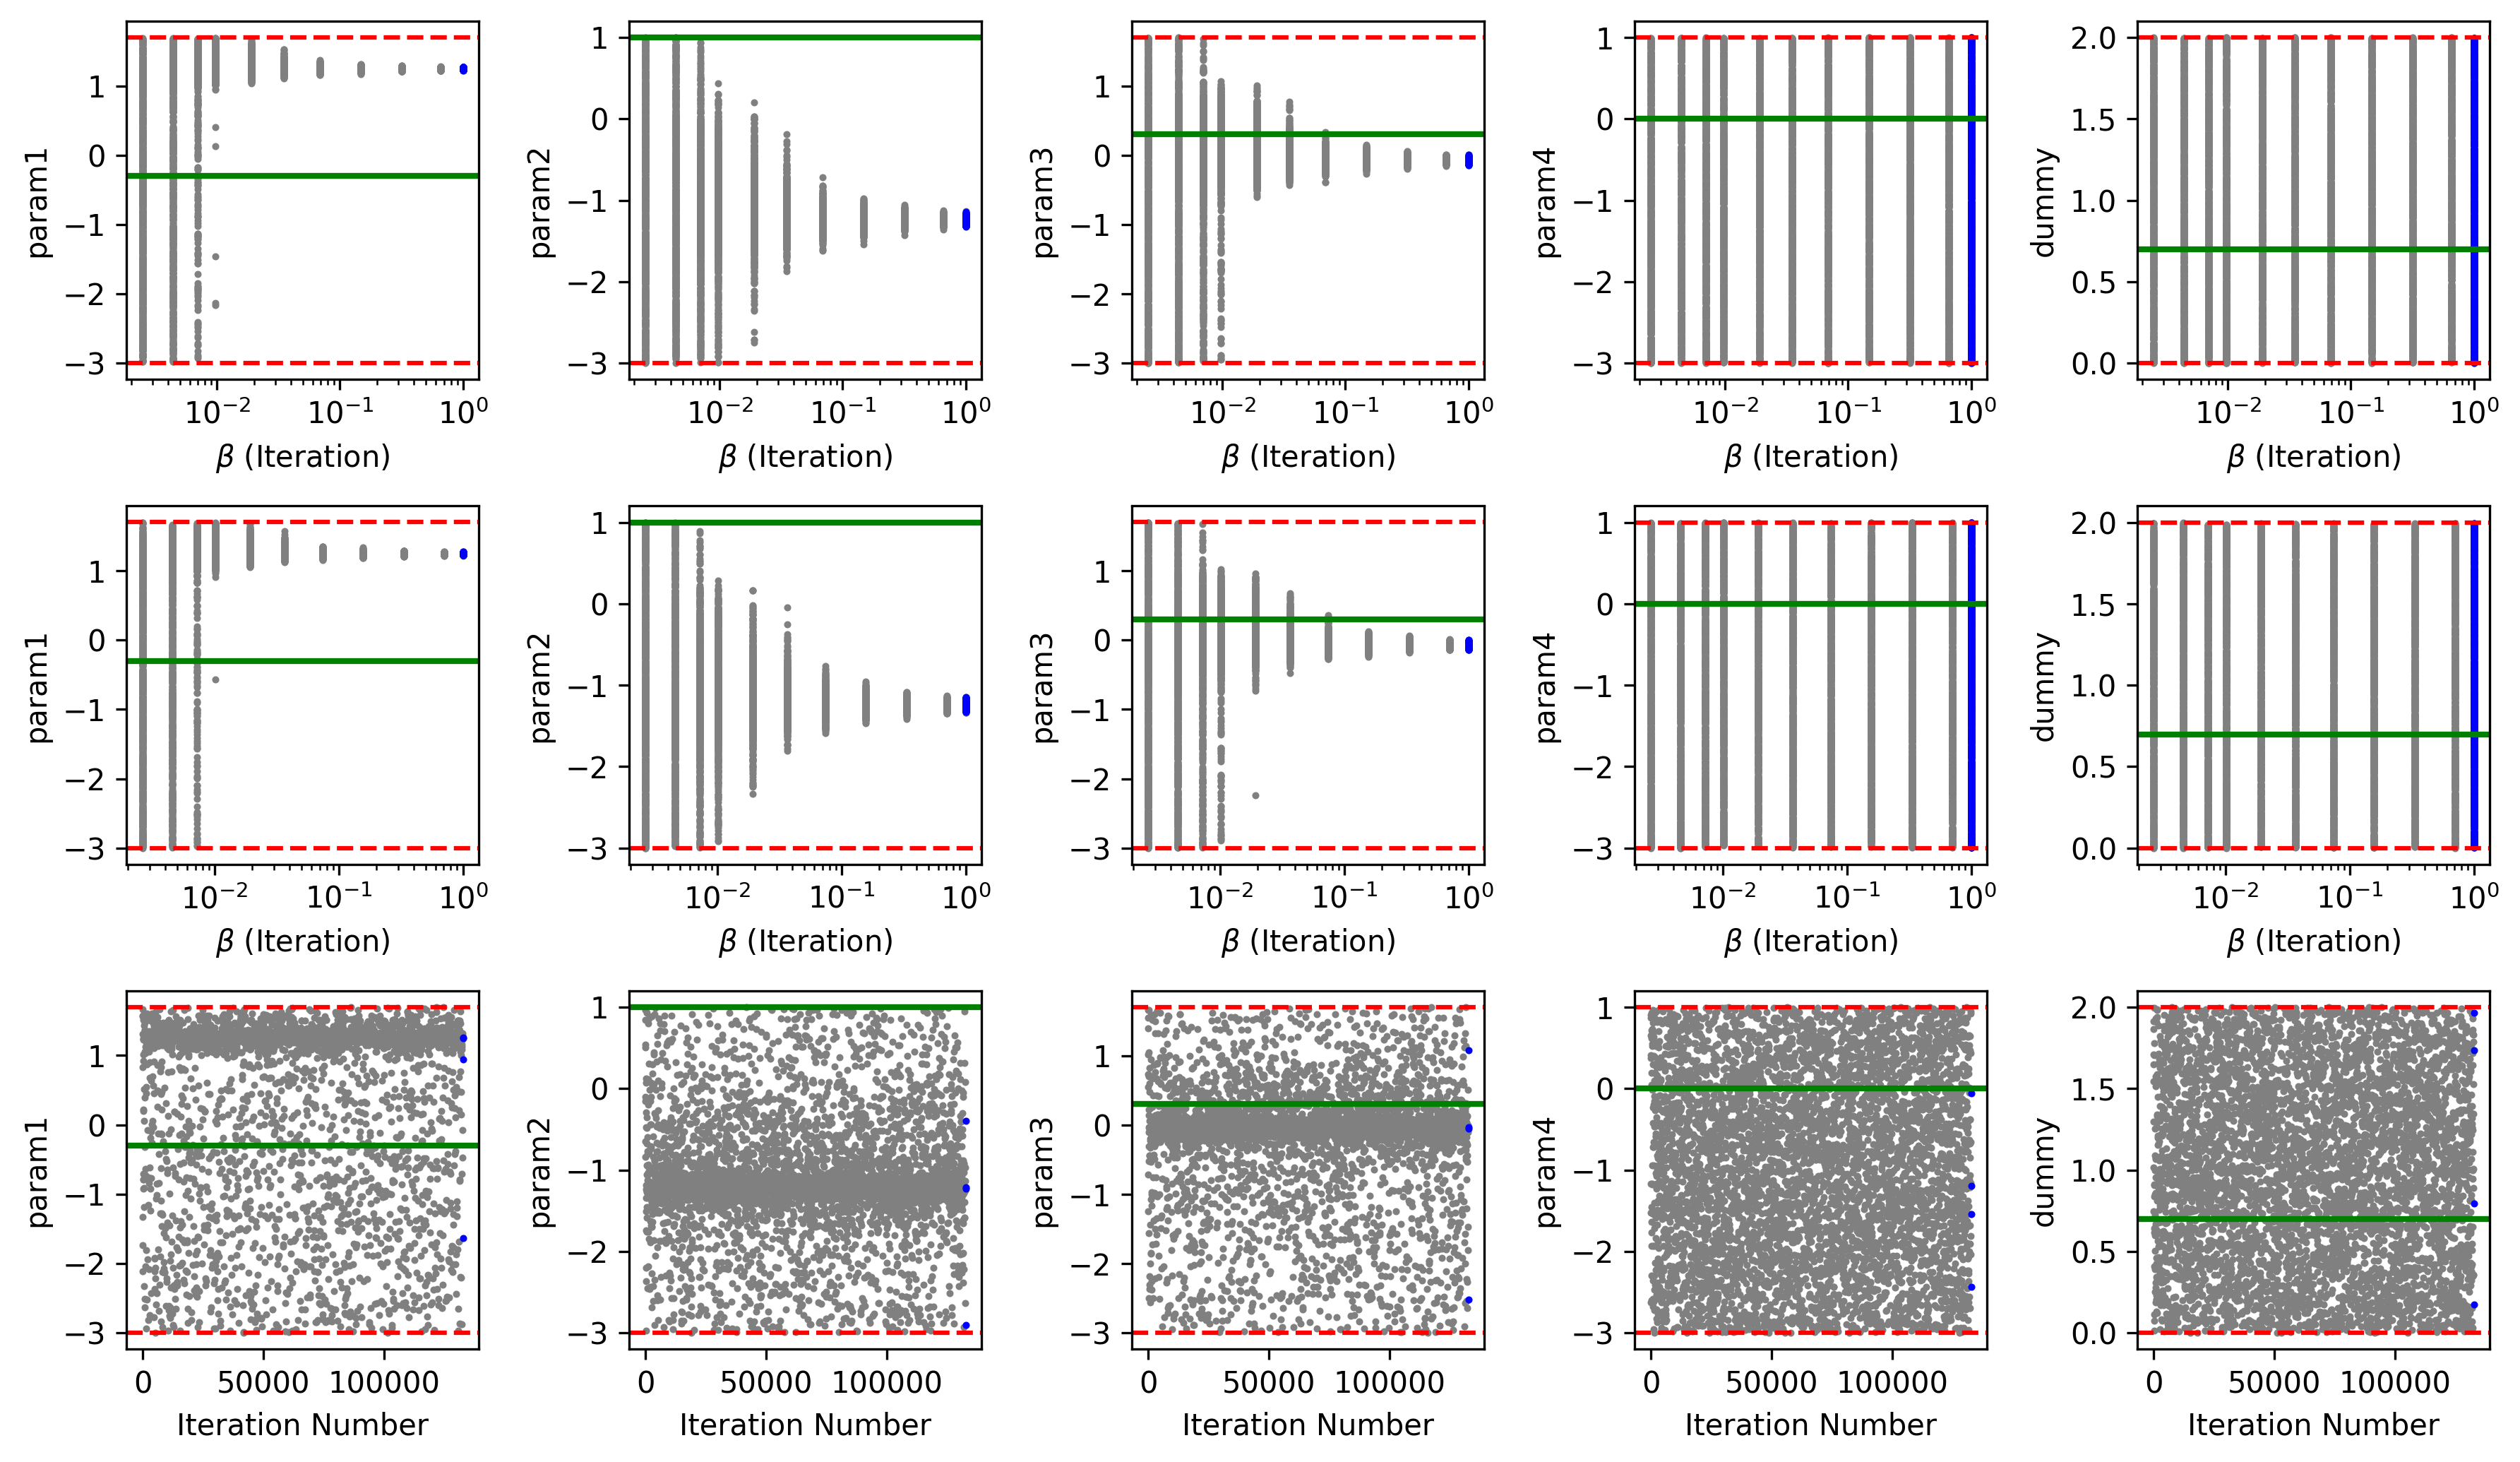

In [10]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)

plt.figure(figsize=(12,7), dpi=300)
fig_num = 1
for j in range(len(best_results)):
	for i, par_name in enumerate(fit_par_names):       
		cur_result = best_results[j]
		#print(f"{i}\t{cur_result.method}")
		#print(int(f"{len(best_results)}{mod_prob.n_dim}{fig_num}"))
		plt.subplot(int(len(best_results)), int(mod_prob.n_dim), fig_num)
		fig_num+=1
		n_iters = cur_result.n_iter
		n_chains = cur_result.n_chains
		n_dim = len(fit_par_names)

		cur_weights = cur_result.all_weights
		cur_trace = cur_result.all_samples[:, :, i]
		iters = cur_result.iters


		# Left column -- beta plots
		for q, it in enumerate(iters):
			if cur_result.method == "ptmcmc":
				if q % 100 != 0:
					continue
			color='grey'
			if q == n_iters - 1:
				color='blue'
			plt.scatter(
				np.full(n_chains, it),
				cur_trace[q, :],
				s=2,
				c=color,
				#alpha=cur_weights[q, :]
			)
	
		# Plot bounds
		plt.axhline(y=np.log10(par_bounds[i][0]), color='r', linestyle='--')
		plt.axhline(y=np.log10(par_bounds[i][1]), color='r', linestyle='--')
		plt.axhline(y=xtrue[i], color="g", lw=2)
		plt.ylabel(par_name)
		if cur_result.method != "ptmcmc":
			plt.xscale('log')
			plt.xlabel(r'$\beta$ (Iteration)')
		else:
			plt.xlabel("Iteration Number")
plt.tight_layout()

In [22]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective
og_obj = obj
if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

## Plot fits to model data

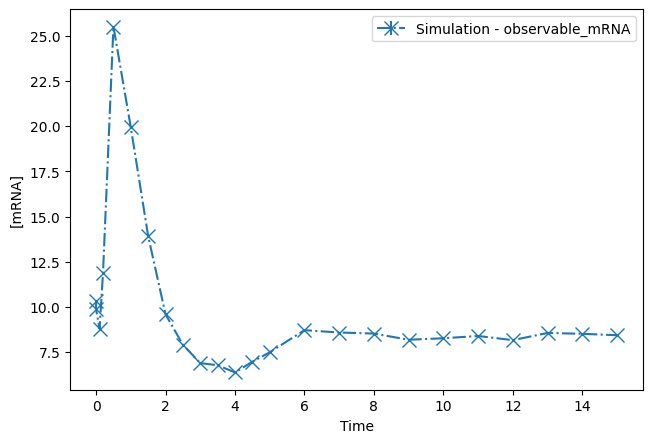

In [12]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

In [45]:
import roadrunner
mod = roadrunner.RoadRunner("mRNA_self_reg/model_mRNA_self_reg.xml")

mod.resetAll()
for x,val in zip(obj.x_names, [0.5,10,2,1,5]):
    mod[x] = val
res = mod.simulate(0,15, 15*10 + 1)
print(res)

    time,    [S1],    [S2],     [S3]
 [[    0,      10,       5,        0],
  [  0.1, 8.89225, 12.4748, 0.426691],
  [  0.2, 12.1445, 20.3721,  1.16229],
  [  0.3, 16.7874, 30.9671,  2.26509],
  [  0.4, 21.5163, 44.5364,  3.84045],
  [  0.5, 25.0765, 60.1411,  5.96665],
  [  0.6, 26.6551, 75.9639,  8.64634],
  [  0.7, 26.3547, 90.1137,  11.7899],
  [  0.8, 24.8793, 101.393,  15.2411],
  [  0.9, 22.9201, 109.458,  18.8228],
  [    1, 20.8985, 114.528,  22.3734],
  [  1.1, 19.0094, 117.069,  25.7641],
  [  1.2,  17.321, 117.595,  28.9023],
  [  1.3, 15.8425,  116.58,  31.7279],
  [  1.4, 14.5591, 114.428,  34.2074],
  [  1.5,  13.448, 111.467,  36.3278],
  [  1.6, 12.4859,  107.96,  38.0914],
  [  1.7, 11.6513, 104.111,  39.5113],
  [  1.8, 10.9257, 100.075,  40.6079],
  [  1.9, 10.2933, 95.9736,  41.4061],
  [    2, 9.74113, 91.8952,  41.9335],
  [  2.1, 9.25819, 87.9059,  42.2185],
  [  2.2,  8.8354,  84.053,  42.2898],
  [  2.3, 8.46524, 80.3698,  42.1749],
  [  2.4,  8.1414, 76.8784,

In [72]:
from collections import OrderedDict
xfull = obj.pre_post_processor.preprocess(best_results[0].posterior_samples[0])
print(xfull)
print(obj.parameter_mapping)
print(obj.x_names)
print(obj.edatas[0].get_observable_ids())
rr = obj.roadrunner_instance
rr.resetAll()
for x,val in zip(obj.x_names, xfull):
    rr[x] = val
#res = rr.simulate(0,15, 15*10 + 1)

calc = obj.calculator
par_map = calc.fill_in_parameters(OrderedDict(zip(obj.x_names, xfull)), rr, obj.parameter_mapping[0])
print(par_map)

parameter_mapping = obj.parameter_mapping[0]
mapping = parameter_mapping[1]  # default: simulation condition mapping
scaling = parameter_mapping[3] 
print(mapping)
print(scaling)


problem_parameters = OrderedDict(zip(obj.x_names, xfull))
def _get_par(model_par, val):
	"""Get parameter value from problem_parameters and mapping.

	Replace parameter IDs in parameter_mapping dicts by values from
	problem_parameters where necessary
	"""
	if isinstance(val, str):
		try:
			# estimated parameter
			return problem_parameters[val]
		except KeyError:
			# condition table overrides must have been handled already,
			# e.g. by the PEtab parameter parameter_mapping, but
			# parameters from InitialAssignments may still be present.
			if mapping[val] == model_par:
				# prevent infinite recursion
				raise
			return _get_par(val, mapping[val])
	if model_par in problem_parameters:
		# user-provided
		return problem_parameters[model_par]
	# prevent nan-propagation in derivative
	if np.isnan(val):
		return 0.0
	# constant value
	return val

mapping_values = {
	key: _get_par(key, val) for key, val in mapping.items()
}
print("-------------------------")
from pypesto.objective.roadrunner.utils import unscale_parameters
mapping_values = unscale_parameters(mapping_values, scaling)
       
print(mapping_values)

[ 1.          1.24091079 -1.26788822 -0.08003663 -0.61152358  0.93116952]
[({}, {'param0': 10.0, 'param1': 'param1', 'param2': 'param2', 'param3': 'param3', 'param4': 'param4', 'dummy': 'dummy'}, {}, {'param0': 'lin', 'param1': 'log10', 'param2': 'log10', 'param3': 'log10', 'param4': 'log10', 'dummy': 'log10'})]
['param1', 'param2', 'param3', 'param4', 'dummy']
['observable_mRNA']
{'param0': 10.0, 'param1': 10.0, 'param2': 17.41449133968647, 'param3': 0.05396495066530494, 'param4': 0.8316936265798073, 'dummy': 0.2446112467130085}
{'param0': 10.0, 'param1': 'param1', 'param2': 'param2', 'param3': 'param3', 'param4': 'param4', 'dummy': 'dummy'}
{'param0': 'lin', 'param1': 'log10', 'param2': 'log10', 'param3': 'log10', 'param4': 'log10', 'dummy': 'log10'}
-------------------------
{'param0': 10.0, 'param1': 10.0, 'param2': 17.41449133968647, 'param3': 0.05396495066530494, 'param4': 0.8316936265798073, 'dummy': 0.2446112467130085}


In [59]:
10**best_results[0].posterior_samples[0]

array([17.41449134,  0.05396495,  0.83169363,  0.24461125,  8.53433183])

In [68]:
sim = obj([0.5,10,2,1,5], mode="mode_fun", return_dict=True)
#print(sim)
sim_df = pd.DataFrame(data=sim["simulation_results"]["simCondition"])
sim_df.to_csv("sanity_check.csv")
"""sim2 = obj(np.log10([0.5,10,2,1,10]), mode="mode_fun", return_dict=True)["llh"]
print(sim2)

sim = obj([0.5,10,2,1,5], mode="mode_fun", return_dict=True)["llh"]
print(sim)

sim = obj([1e-3,1e-3,1e-3,10,5], mode="mode_fun", return_dict=True)["llh"]
print(sim)

"""
test = obj(best_results[0].posterior_samples[0], mode="mode_fun", return_dict=True)
print(test)
print(best_results[0].posterior_samples[0])
print(10**(10**best_results[0].posterior_samples[0]))
#test = mod_prob.log_likelihood_wrapper(best_results[0].posterior_samples[0])
#print(test)	

{'fval': 52.21680426496509, 'simulation_results': {'simCondition':       time, observable_mRNA
 [[      0,              10],
  [ 0.0001,         9.99788],
  [    0.1,         10.5355],
  [    0.2,         12.7138],
  [    0.5,         19.8582],
  [      1,         22.4074],
  [    1.5,         14.4895],
  [      2,         8.59441],
  [    2.5,         5.99644],
  [      3,         5.20478],
  [    3.5,         5.44898],
  [      4,         6.43717],
  [    4.5,          7.9269],
  [      5,         9.43753],
  [      6,         10.3131],
  [      7,         8.94007],
  [      8,         8.16787],
  [      9,         8.41212],
  [     10,         8.89094],
  [     11,         8.97539],
  [     12,         8.78084],
  [     13,         8.66625],
  [     14,         8.70826],
  [     15,         8.77924]]
}, 'llh': -52.21680426496509}
[ 1.24091079 -1.26788822 -0.08003663 -0.61152358  0.93116952]
[2.59711595e+17 1.13230898e+00 6.78724657e+00 1.75635073e+00
 3.42240836e+08]


In [ ]:
measure_df = petab_prob.measurement_df
plt.figure(figsize=(6,4), dpi=300)
plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)
lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(measure_df.shape[0], pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
		
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]

	plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=best.method, zorder=1, color=colors[i])
	plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend()
plt.xlabel("Time"); plt.ylabel("[Product]");

['S1', 'S2', 'S3']

param1 1.2409107936611194 1.2409107936611194
param2 -1.2678882156346847 -1.2678882156346847
param3 -0.08003662658181199 -0.08003662658181199
param4 -0.6115235788896332 -0.6115235788896332
dummy 0.9311695248828268 0.9311695248828268

param1 1.2521167313800525 1.2521167313800525
param2 -1.2100660120481563 -1.2100660120481563
param3 -0.06067818206397879 -0.06067818206397879
param4 -1.0649182307347833 -1.0649182307347833
dummy 0.35549299927992606 0.35549299927992606


Error: CVODE Error: CV_TOO_MUCH_ACC, Module: CVODES, Function: CVode, Message: At t = 4.21783, too much accuracy requested.


RuntimeError: CVODE Error: CV_TOO_MUCH_ACC: The solver could not satisfy the accuracy demanded by the user for some internal step.; In virtual double rr::CVODEIntegrator::integrate(double, double)

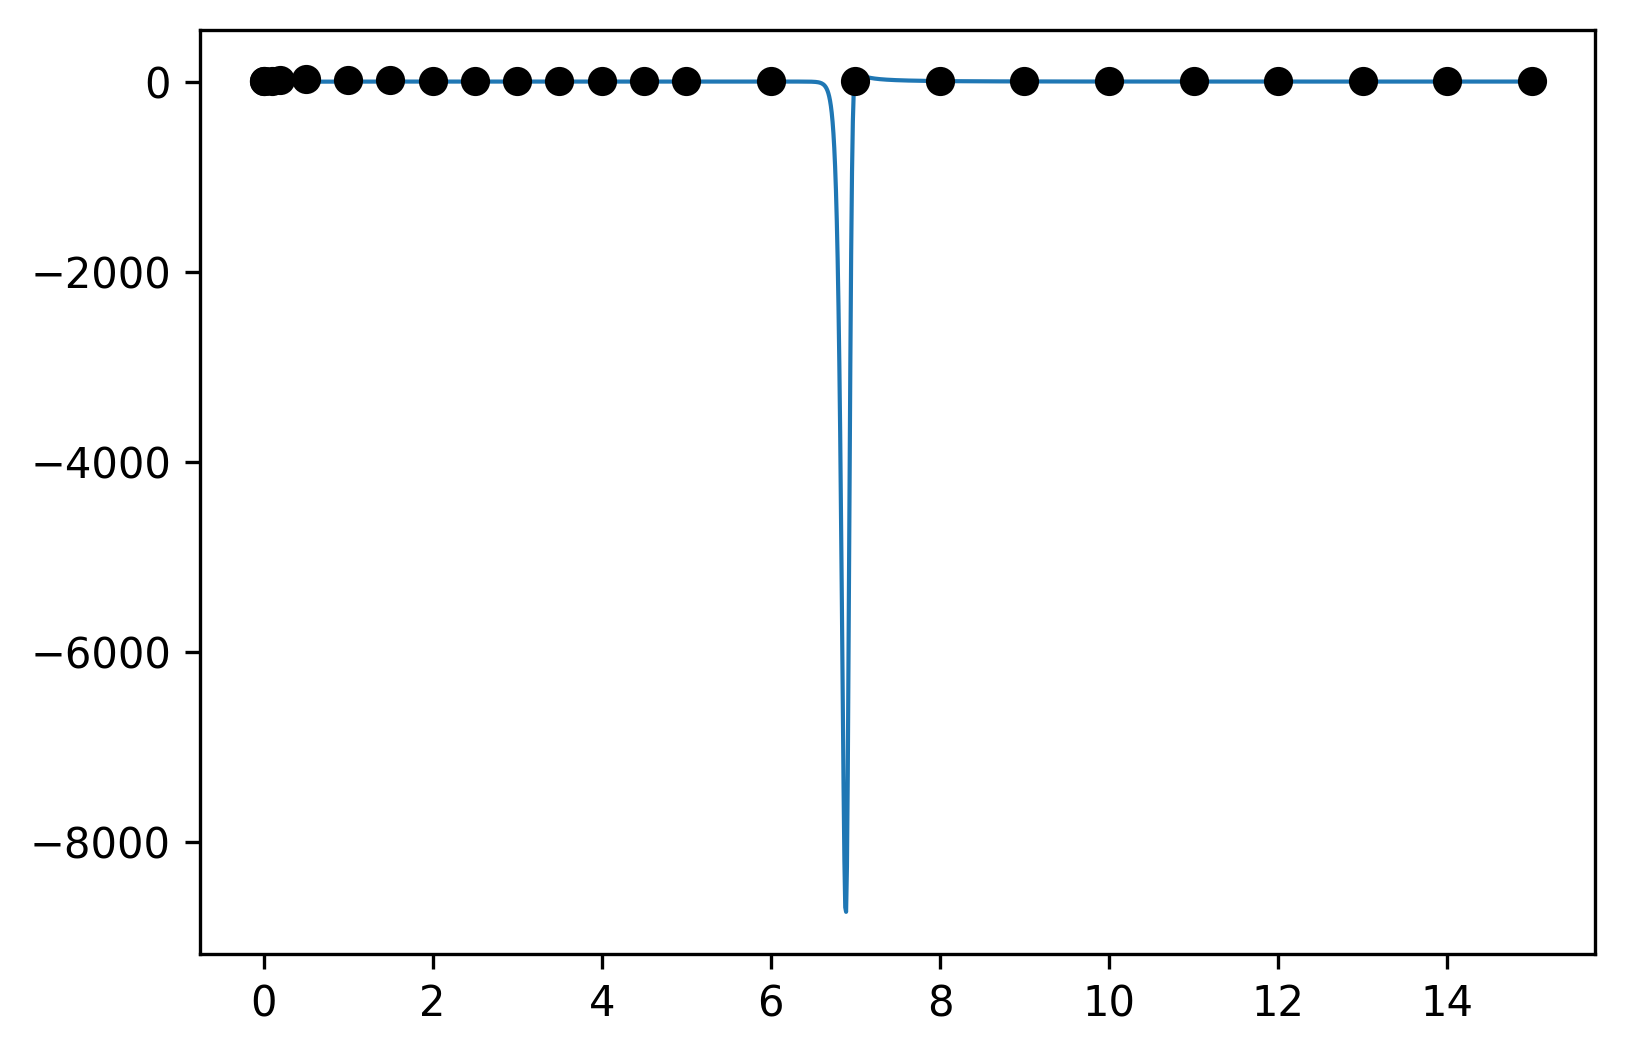

In [62]:
measure_df = petab_prob.measurement_df
plt.figure(figsize=(6,4), dpi=300)
plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)

max_t = np.max(measure_df["time"])
n_sim_ts = int(max_t*100 + 1)
simu = obj.roadrunner_instance
print(simu.model.getFloatingSpeciesIds())

lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(n_sim_ts, pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		#sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		simu.resetAll()
		print()
		label=n
		if n > 5:
			par = np.log10([0.5,10,2,1,5])
		for name, x in zip(fit_par_names, par):
			simu[name] = x
			print(name, x, simu[name])
		simu.reset()
		sim = simu.simulate(0, max_t, n_sim_ts)
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
		plt.plot(sim_ts, sim[:,1], lw=1, zorder=1, label=label)#, color=colors[i])
		if n == 5:
			break
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]
	
	#plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=best.method, zorder=1, color=colors[i])
	break
	#plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend()
plt.xlabel("Time"); plt.ylabel("[mRNA]");